<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
from datetime import datetime

In [5]:
def add_index(df, user_id):
    df['user_id'] = user_id

In [6]:
def init_DF(path):
    num = 1
    
    DF = pd.DataFrame()

    for file in glob(path + '/*'):
        df = pd.read_csv(file, sep=",")
        add_index(df, num)
        DF = DF.append(df, ignore_index = True)
        num += 1
    return DF, num

In [7]:
#важно обрезать последний элемент массива, потому что считает разницу времени посещения последнего сайта в этой сессии
# с первым элементом следующей сессии

def add_zeros_time(x, session_length):
    if len(x) % session_length == 0:
        return x
    return np.concatenate((x[:-1], np.zeros(session_length - len(x) % session_length + 1, dtype=int)))

In [8]:
def flat_time(X, session_length, window_size):
    z = np.array([], dtype=int).reshape(0, session_length)
    
    for start in range(0, len(X), window_size):
        z = np.vstack((z, add_zeros_time(X[start : start + session_length], session_length)))
    return z

In [9]:
def add_zeros(x, session_length):
    if len(x) % session_length == 0:
        return x
    return np.concatenate((x, np.zeros(session_length - len(x) % session_length, dtype=int)))

In [10]:
def flat(X, session_length, window_size):
    z = np.array([], dtype=int).reshape(0, session_length)
    start_ind = [] 
    fin_ind = []
    
    for start in range(0, len(X), window_size):
        z = np.vstack((z, add_zeros(X[start : start + session_length], session_length)))
        start_ind.append(start)
        fin_ind.append(start + len(X[start : start + session_length]))
    return z, start_ind, fin_ind

In [11]:
def timespan(df, start_ind, fin_ind):
    session_timespan = np.array([], dtype = int)
    start_hour = np.array([], dtype = int)
    day_of_week = np.array([], dtype = int)
    
    for i in range(len(start_ind)):
        session = df[start_ind[i]:fin_ind[i]]
        ms = min(session)
        session_timespan = np.append(session_timespan, int((max(session) - ms).total_seconds()))
        start_hour = np.append(start_hour, ms.hour)
        day_of_week = np.append(day_of_week, ms.weekday())
    return session_timespan, start_hour, day_of_week

In [12]:
def create_df(DF, num, session_length, window_size, feature_names):
    X = np.array([], dtype=int).reshape(0, session_length  * 2 + 4)  
    
    for i in range(1, num):
        x, start_ind, fin_ind = flat(np.array(DF[DF['user_id'] == i].site_id), session_length, window_size)        
        t_diff = np.array(flat_time(np.array(DF[DF['user_id'] == i].timediff), session_length - 1, window_size), dtype=int)
        
        session_timespan, start_hour, day_of_week = timespan(DF['timestamp'][DF['user_id'] == i], start_ind, fin_ind)
        
        unique_sites = np.array([np.count_nonzero(np.unique(el)) for el in x], dtype = int)
        target = np.array([i] * x.shape[0], dtype=int)
        
        X = np.vstack((X, np.hstack((x, t_diff, session_timespan[:, np.newaxis], unique_sites[:, np.newaxis], 
                      start_hour[:, np.newaxis], day_of_week[:, np.newaxis], target[:, np.newaxis]))))
        
    train_data = pd.DataFrame(X, columns = feature_names)
    return train_data

In [13]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    DF, num = init_DF(path_to_csv_files)
    DF['site_id'], DF['site_freq'] = zip(*DF['site'].map(site_freq))
    DF.timestamp = DF.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    DF['timediff'] = (DF['timestamp'].shift(-1) - DF['timestamp']).apply(lambda x: x.total_seconds())
    return create_df(DF, num, session_length, window_size, feature_names)

**Проверим функцию на игрушечном примере.**

In [14]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [15]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,8,2,1,9,5,11,7,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,10,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [16]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 7.8 s


In [17]:
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [18]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,193,578,134,3,134,134,3,134,204,134,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,418,192,679,254,134,31,400,4342,219,55,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,55,3,55,55,5,294,418,337,912,55,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,476,3505,476,55,55,55,55,996,202,124,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,343,55,5,3930,259,211,3973,2349,702,2349,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [19]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 29s


In [20]:
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [21]:
new_features_10users = train_data_10users.loc[:,'session_timespan':'day_of_week']
new_features_150users = train_data_150users.loc[:,'session_timespan':'day_of_week']

In [22]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [23]:
np.median(new_features_10users.session_timespan)

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [24]:
np.median(new_features_10users.day_of_week)

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [25]:
np.median(new_features_150users.start_hour)

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [26]:
np.median(new_features_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [27]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [28]:
#проверим, что имена записались во все сессии
train_data_10users.target.value_counts()

Bill         2796
Lindsey      2204
John         1868
Bob          1712
Dick         1643
Ashley       1022
Naomi         802
Mary-Kate     760
Avril         720
Ed            534
Name: target, dtype: int64

In [29]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

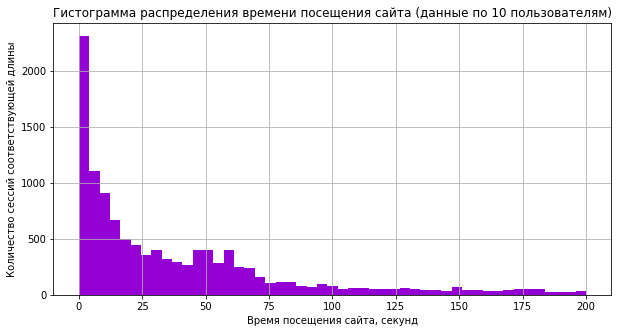

In [30]:
train_data_10users['session_timespan'].hist(bins=np.linspace(0, 200), color='darkviolet', figsize=(10,5))
plt.title('Гистограмма распределения времени посещения сайта (данные по 10 пользователям)')
plt.xlabel('Время посещения сайта, секунд')
plt.ylabel('Количество сессий соответствующей длины')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

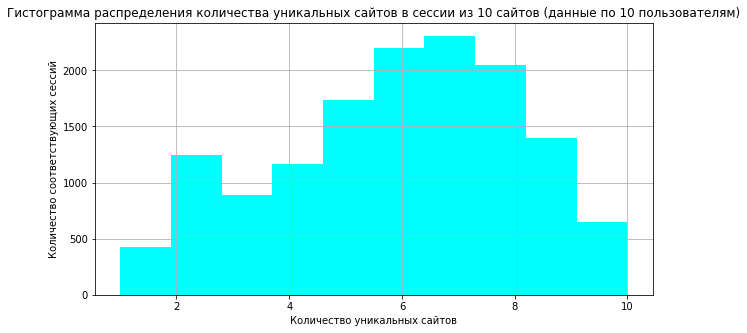

In [31]:
train_data_10users['#unique_sites'].hist(color='aqua', figsize=(10,5))
plt.title('Гистограмма распределения количества уникальных сайтов в сессии из 10 сайтов (данные по 10 пользователям)')
plt.xlabel('Количество уникальных сайтов')
plt.ylabel('Количество соответствующих сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

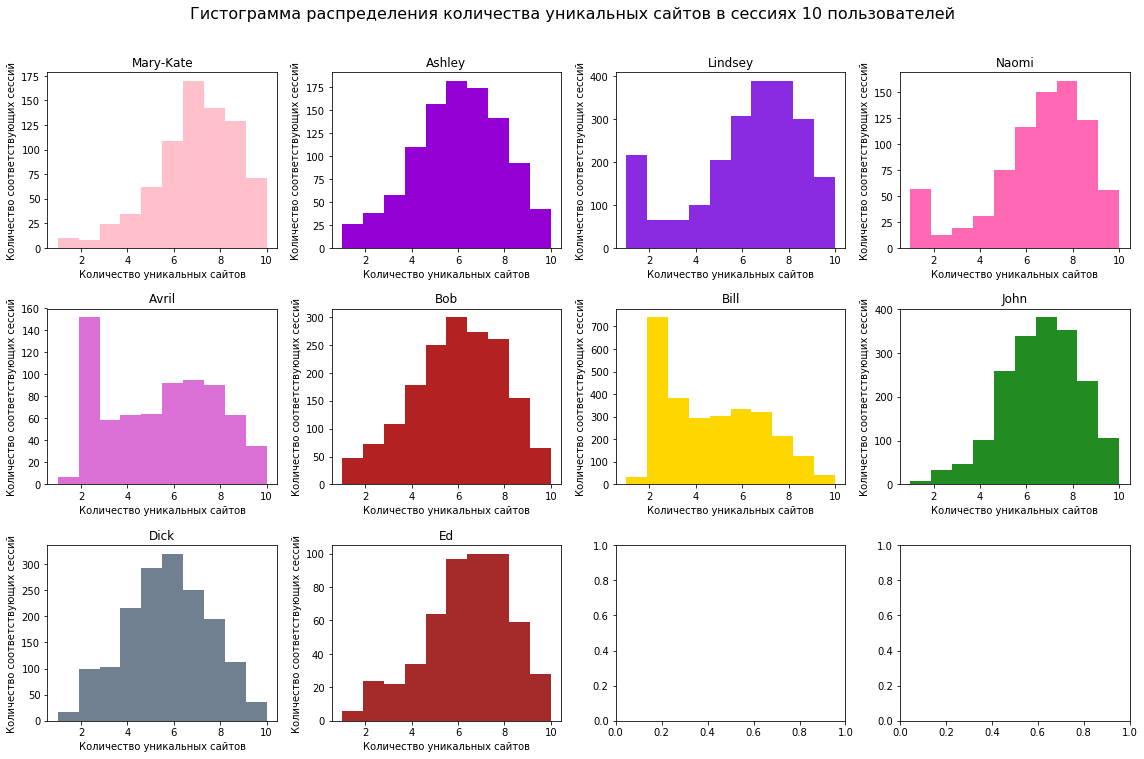

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), train_data_10users.target.unique())):
    x = train_data_10users.loc[train_data_10users.target==target, '#unique_sites']
    ax.hist(x, label=str(target), color=color_dic[target])
    ax.set_title(target)
    ax.set_xlabel('Количество уникальных сайтов')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения количества уникальных сайтов в сессиях 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

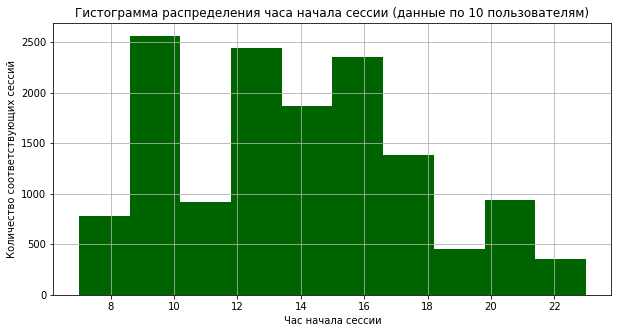

In [33]:
train_data_10users['start_hour'].hist(color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения часа начала сессии (данные по 10 пользователям)')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

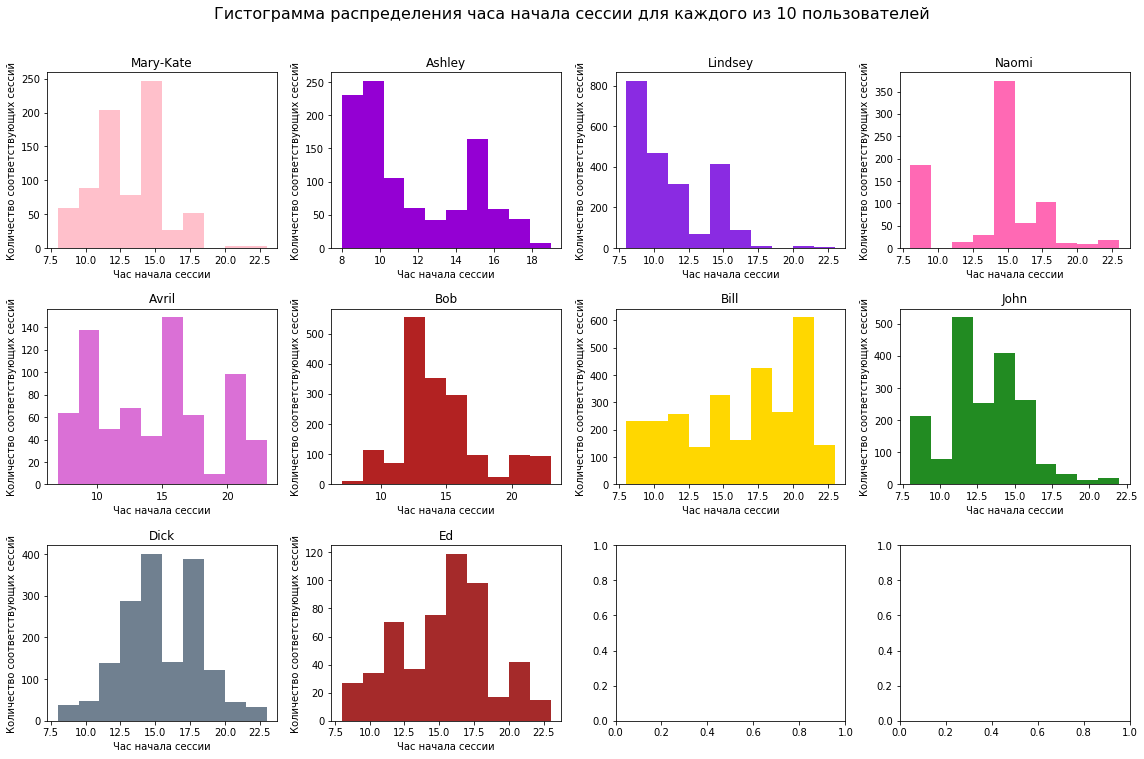

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), train_data_10users.target.unique())):
    x = train_data_10users.loc[train_data_10users.target==target, 'start_hour']
    ax.hist(x, label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    ax.set_xlabel('Час начала сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения часа начала сессии для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

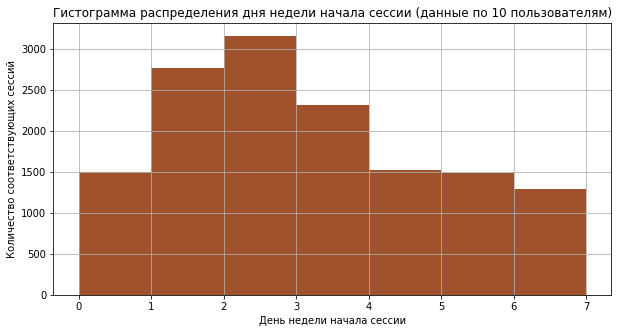

In [35]:
train_data_10users['day_of_week'].hist(color='sienna', figsize=(10,5), bins=range(8))
plt.title('Гистограмма распределения дня недели начала сессии (данные по 10 пользователям)')
plt.xlabel('День недели начала сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

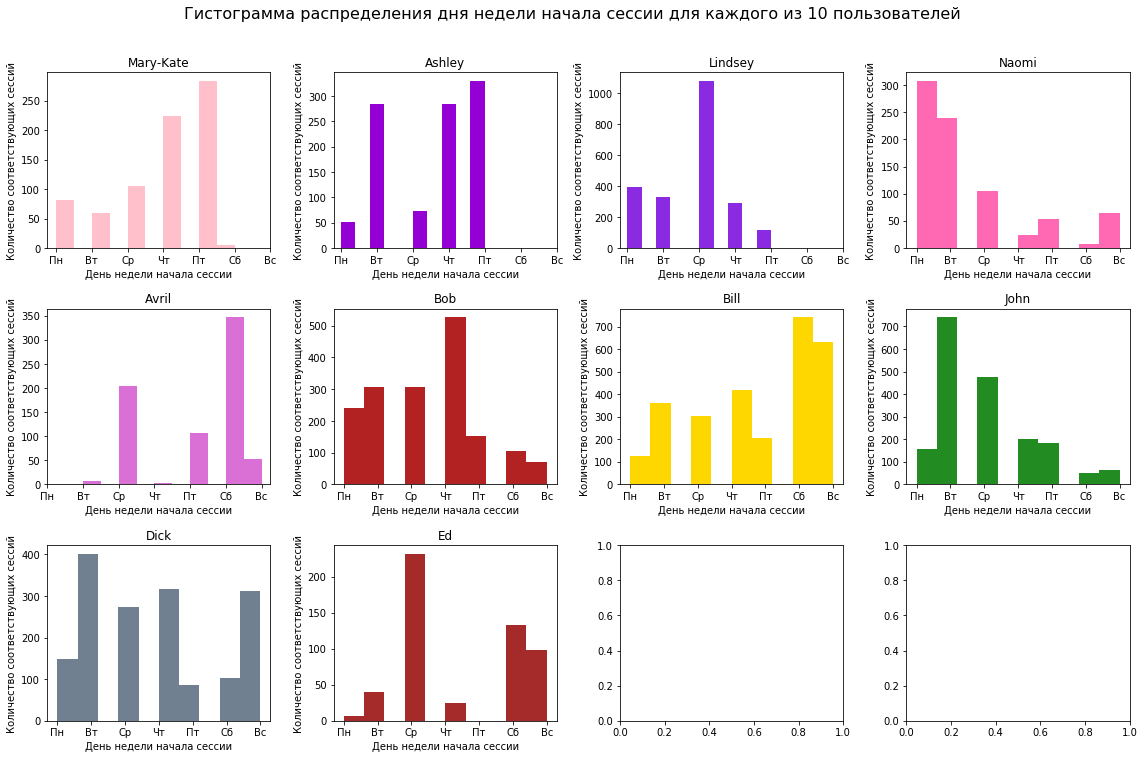

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
weekdays = ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс')

for idx, (ax, target) in enumerate(zip(axes.flatten(), train_data_10users.target.unique())):
    x = train_data_10users.loc[train_data_10users.target==target, 'day_of_week']
    ax.hist(x, label=str(target), color=color_dic[target]) #, bins=range(8)
    ax.set_title(target)
    ax.set_xticks(range(0, 7))
    ax.set_xticklabels(weekdays)
    ax.set_xlabel('День недели начала сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения дня недели начала сессии для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Поскольку целью данной работы является идентификация пользователей по посещенным веб-страницам, имеет смысл искать те признаки, по которым пользователи сильно отличаются друг от друга. Так, например, гистограмма распределения кол-ва уникальных сайтов в сессии у большинства пользователей похожа. Существенно отличаются от общей гистограммы по 10 пользователям только Bill и Avril. Однако в комбинации с другими признаками этот показатель может быть полезен впоследствии.

Гистограммы распределения часа начала сессии и дня недели начала сессии у пользователей существенно отличаются.  Есть пользователи, которые заходят преимущественно в будние дни и в определенные часы (Mary-Kate, Ashley, Lindsey, Bob, John). Можно предположить, что эти люди выходят в интернет на работе или учебе. Avril, Bill больше посещают интернет в выходные. Naomi и Ed преимущественно посещают интернет в определенные будние дни (пн-вт и ср соответственно). У них самые необычные паттерны, их идентифицировать легче остальных. Dick не имеет четкого паттерна, его опознать сложнее остальных.

С точки зрения часа начала сессии многие пользователи имеют наибольший или второй пик посещения в районе 15 часов (M-K, Naomi, Avril, Dick, Ed, John). У остальных пользователей (Ashley, Lindsey, Bob, Bill) это третий пик. Можно предположить, что примерно в это время люди возвращаются с обеда. Также часть пользователей имеют утренние пики в промежутке с 7 до 10 часов (Ashley, Lindsey, Naomi, Avril, John). Вечерние пики (после 20 часов) имеют только Bill и Avril.

Исходя из комбинации дней начала посещения и пиковых часов можно попробовать идентифицировать пользователей.

Также можно попробовать разделить посещенные сайты на условно "развлекательные" и "рабочие" и сопоставить часы начала сессии и посещенные сайты.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [37]:
site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_10users.pkl')

with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [38]:
import operator

In [39]:
#словарь можно не сортировать, потому что он хранится уже отсортированным
#sorted_freq = sorted(site_freq.items(), key=operator.itemgetter(1))
top10_sites = list(site_freq.keys())[:10]
top10_freqs = [x[1] for x in list(site_freq.values())[:10]]

In [40]:
top10_sites

['s.youtube.com',
 'www.google.fr',
 'www.google.com',
 'mail.google.com',
 'www.facebook.com',
 'apis.google.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'plus.google.com',
 'accounts.google.com']

In [41]:
top10_freqs

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

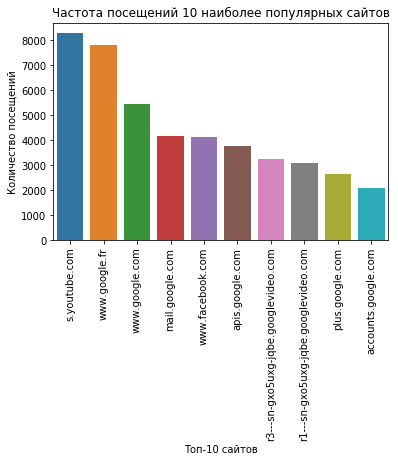

In [42]:
freq_plot = sns.barplot(top10_sites, top10_freqs)
freq_plot.set_xticklabels(freq_plot.get_xticklabels(), rotation=90)
freq_plot.set_xlabel('Топ-10 сайтов')
freq_plot.set_ylabel('Количество посещений')
freq_plot.set_title('Частота посещений 10 наиболее популярных сайтов');

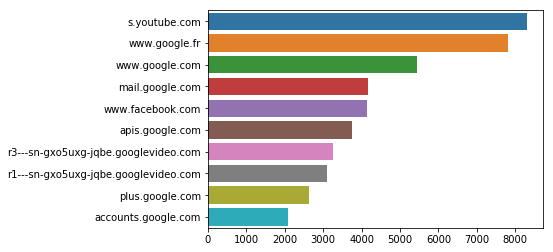

In [43]:
# в качестве альтернативы можно предложить повернуть сам график
sns.barplot(top10_freqs, top10_sites);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Возьмем следующий набор признаков:

- количество развлекательных сайтов в сессии (для простоты возьмем под развлекательными все страницы youtube и facebook)
- средняя продолжительность посещения развлекательных сайтов в сессии
- количество сайтов из топ-30 в сессии
- средняя продолжительность посещения сайтов из топ-30 в сессии
- время суток начала сессии

Напишем функции, добавляющие в датафрейм соответствующий признак

In [44]:
# функция, достающая из словаря индексы всех сайтов, в домене которых встречается заданное слово
extract = lambda site, site_freq: [value[0] for key, value in site_freq.items() if site in key.lower()]

In [65]:
def get_logs(sites, site_freq):
    entertainm = []
    for site in sites:
        entertainm += extract(site, site_freq)
    return entertainm

In [67]:
def add_num_entertainm(data, X, site_freq, entertainm):  
    data['num_entertainm'] = [np.sum([np.count_nonzero(x == item) for item in entertainm]) for x in X]

In [68]:
def add_time_entertainm(data, X_td, entertainm):
    data['time_entertainm'] = [np.mean([time for site, time in zip(x[:9], x[10:]) 
                                                if time > 0 and site in entertainm]) for x in X_td]
    data['time_entertainm'].fillna(0, inplace = True)

In [47]:
# Поскольку словарь упорядочен по убыванию, наиболее посещаемые сайты имеют в нем индексы, начиная с 1.
def add_num_top30(data, X):
    top_30 = range(1,31)
    data['num_top_30'] = [np.sum([np.count_nonzero(x == item) for item in top_30]) for x in X]

In [71]:
def add_time_top_30(data, X_td):
    top_30 = range(1,31)
    data['time_top_30'] = [np.mean([time for site, time in zip(x[:9], x[10:]) 
                                            if time > 0 and site in top_30]) for x in X_td]
    data['time_top_30'].fillna(0, inplace = True)

In [49]:
# для простоты будет считать, что сутки делятся так: 7-10 утро, 11-16 день, 17-23 вечер. Остальное ночь.
# При ошибке возвращаем -1
def dt(x):
    if x < 0 or x > 24:
        return -1
    if x < 8 or x > 23:
        return 0
    if x < 11:
        return 1
    if x < 17:
        return 2
    return 3

In [50]:
def add_day_time(data):
    data['time_of_day'] = data['start_hour'].apply(dt)

In [69]:
# функция, добавляюзая запрошенные признаки
def add_new_features(data, features, site_freq):
    X = np.array(data.loc[:,'site1':'site10'])
    X_td = np.array(data.loc[:,'site1':'time_diff9'])
    entertainm = get_logs(('facebook','youtube'), site_freq)
    if 'num_entertainm' in features: add_num_entertainm(data, X, site_freq, entertainm)
    if 'time_entertainm' in features: add_time_entertainm(data, X_td, entertainm)
    if 'num_top30' in features: add_num_top30(data, X)
    if 'time_top_30' in features: add_time_top_30(data, X_td)
    if 'day_time' in features: add_day_time(data)

In [52]:
# для создания датафрейма используется функция, написанная выше
# далее к нему можно добавить признаки из нового набора (['num_entertainm', 'time_entertainm', 'num_top30', 'time_top_30', 'day_time'])
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
    
    data = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=session_length, window_size=window_size)
    
    add_new_features(data, features, site_freq)
    
    return data

In [53]:
features = ['num_entertainm', 'time_entertainm', 'num_top30', 'time_top_30', 'day_time']

In [72]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                        '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=features)

In [73]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,num_entertainm,time_entertainm,num_top_30,time_top_30,time_of_day
0,193,578,134,3,134,134,3,134,204,134,10,0,...,1,0,33,5,8,4,1,0,0.0,2,1.0,1
1,418,192,679,254,134,31,400,4342,219,55,1,0,...,3,8,284,10,8,4,1,0,0.0,0,0.0,1
2,55,3,55,55,5,294,418,337,912,55,0,14,...,0,0,258,7,8,4,1,1,0.0,2,14.0,1
3,476,3505,476,55,55,55,55,996,202,124,2,1,...,0,0,30,6,8,4,1,0,0.0,0,0.0,1
4,343,55,5,3930,259,211,3973,2349,702,2349,1,0,...,1,0,6,9,8,4,1,1,1.0,1,1.0,1


In [74]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                        '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=features)

In [75]:
new_features_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,num_entertainm,time_entertainm,num_top_30,time_top_30,time_of_day
0,1,1,4,2,1,4,1,2,1291,322,1,1,...,49,0,57,5,8,4,1,0,0.0,8,9.500000,1
1,2,23,1517,1291,322,322,113,73,49,49,0,0,...,1504,4,1618,8,8,4,1,0,0.0,2,0.000000,1
2,322,205,1,1,1,1,73,322,2,1,1,10,...,0,4,2010,5,8,4,1,0,0.0,6,16.400000,1
3,1,1,7509,7509,5552,7509,7509,1,35,1,1,0,...,6,0,2006,4,9,4,1,0,0.0,4,3.500000,1
4,1,1,76,1,58,50,58,50,83,76,4,3,...,1,0,10,5,9,4,1,0,0.0,3,2.666667,1


In [76]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [77]:
# проделаем с выборкой из 10 пользователей ту же операцию по замене индексов на имена.
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [78]:
# Визуализировать 150 пользователей неудобно, поэтому возьмем 12 случайных пользователей и будем смотреть на них.
# 12, потому что удобно ложатся на сетку
import random
rand_target = random.sample(range(1, 151), 12)
new_features_150users_r12 = new_features_150users[new_features_150users['target'].isin(rand_target)]

In [79]:
# переименуем метки на более понятные
new_id_dict = {key: value for (key, value) in zip(rand_target, range(1, 13))}
new_features_150users_r12['target'] = new_features_150users_r12['target'].map(new_id_dict)

Посмотрим поочередно на полученные признаки

Сначала - кол-во развлекательных сайтов в сессии

In [80]:
new_features_10users.num_entertainm.value_counts()

0     7586
1     1953
3     1224
4     1171
2     1053
5      501
6      284
7      155
8       65
10      42
9       27
Name: num_entertainm, dtype: int64

примерно в половине сессий развлекательные сайты вообще не встречаются, поэтому имеет смысл исключать 0 из гистограмм

In [81]:
new_features_10users_nz = new_features_10users[new_features_10users['num_entertainm'] > 0]
new_features_150users_nz = new_features_150users[new_features_150users['num_entertainm'] > 0]
new_features_150users_r12_nz = new_features_150users_r12[new_features_150users_r12['num_entertainm'] > 0]

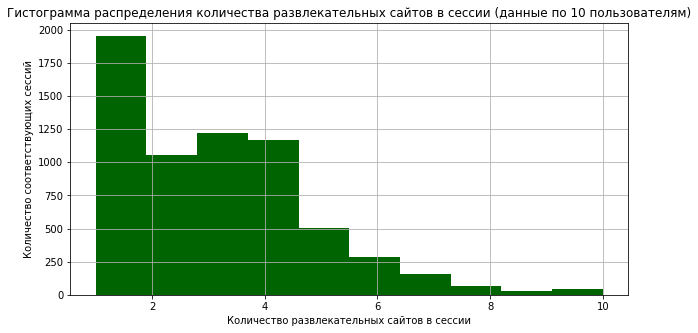

In [82]:
new_features_10users_nz['num_entertainm'].hist(color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения количества развлекательных сайтов в сессии (данные по 10 пользователям)')
plt.xlabel('Количество развлекательных сайтов в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

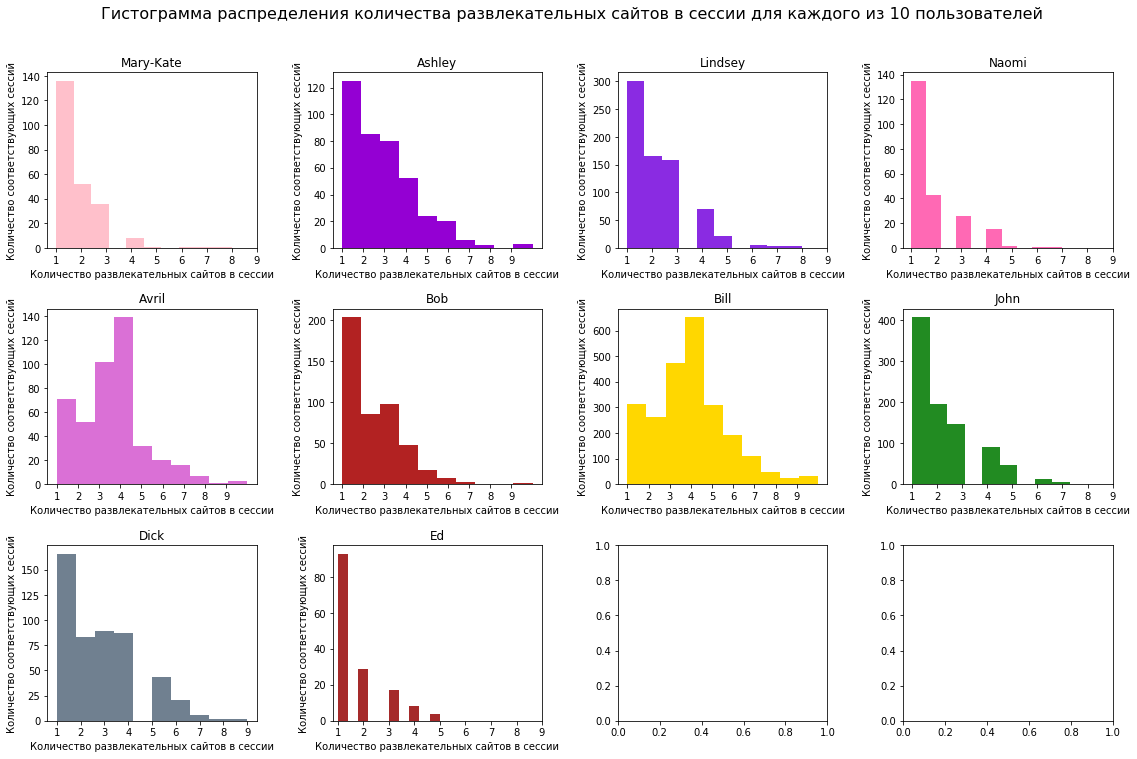

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_10users_nz.target.unique())):
    x = new_features_10users_nz.loc[new_features_10users_nz.target==target, 'num_entertainm']
    ax.hist(x, label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    ax.set_xticks(range(1, 10))
    ax.set_xlabel('Количество развлекательных сайтов в сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения количества развлекательных сайтов в сессии для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

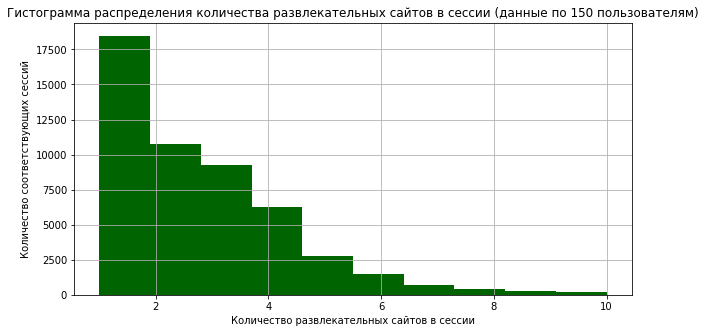

In [84]:
new_features_150users_nz['num_entertainm'].hist(color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения количества развлекательных сайтов в сессии (данные по 150 пользователям)')
plt.xlabel('Количество развлекательных сайтов в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

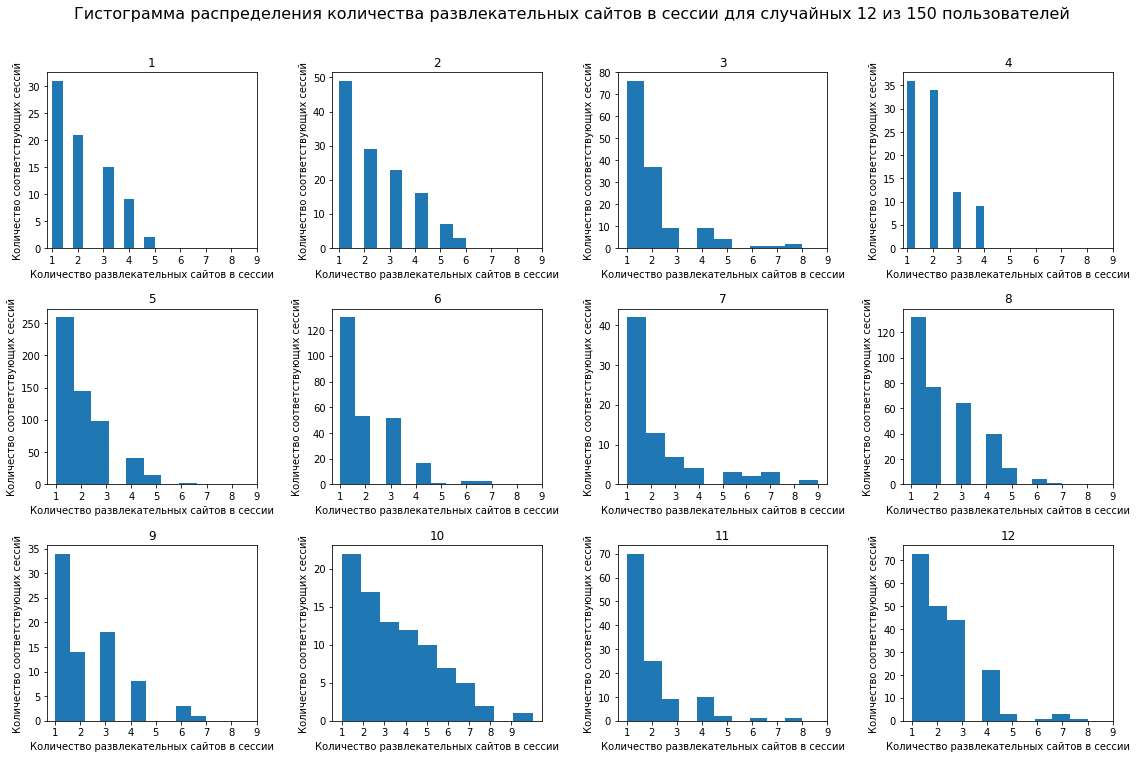

In [85]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), range(1, 13))):
    x = new_features_150users_r12_nz.loc[new_features_150users_r12_nz.target==target, 'num_entertainm']
    ax.hist(x, label=str(target)) #, bins=range(24)
    ax.set_title(target)
    ax.set_xticks(range(1, 10))
    ax.set_xlabel('Количество развлекательных сайтов в сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения количества развлекательных сайтов в сессии для случайных 12 из 150 пользователей', y=1.05, size = 16)
plt.tight_layout();

Далее - среднее время посещения развлекательных сайтов

In [86]:
# Здесь также имеет смысл исключить нули. Более того, в выборке очень много сессий со временем посещения меньше секунды.
# для наглядности лучше взять время посещения больше секунды
new_features_10users_te_nz = new_features_10users[new_features_10users['time_entertainm'] > 1]
new_features_150users_te_nz = new_features_150users[new_features_150users['time_entertainm'] > 1]
new_features_150users_r12_te_nz = new_features_150users_r12[new_features_150users_r12['time_entertainm'] > 1]

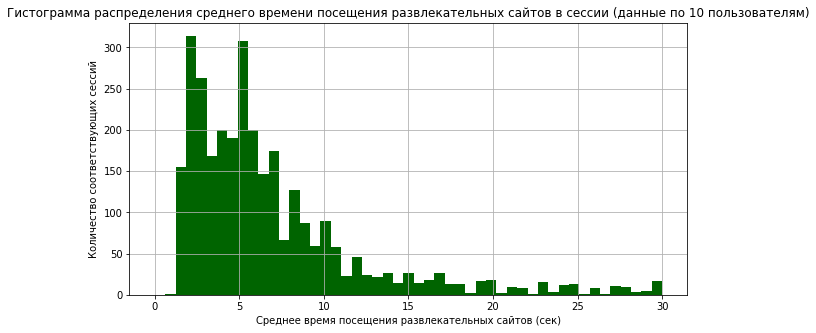

In [87]:
# на гистограмме имеет смысл ограничить ось значением в 30 секунд, иначе ничего не видно
new_features_10users_te_nz['time_entertainm'].hist(bins=np.linspace(0, 30), color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения среднего времени посещения развлекательных сайтов в сессии (данные по 10 пользователям)')
plt.xlabel('Среднее время посещения развлекательных сайтов (сек)')
plt.ylabel('Количество соответствующих сессий')
plt.show()

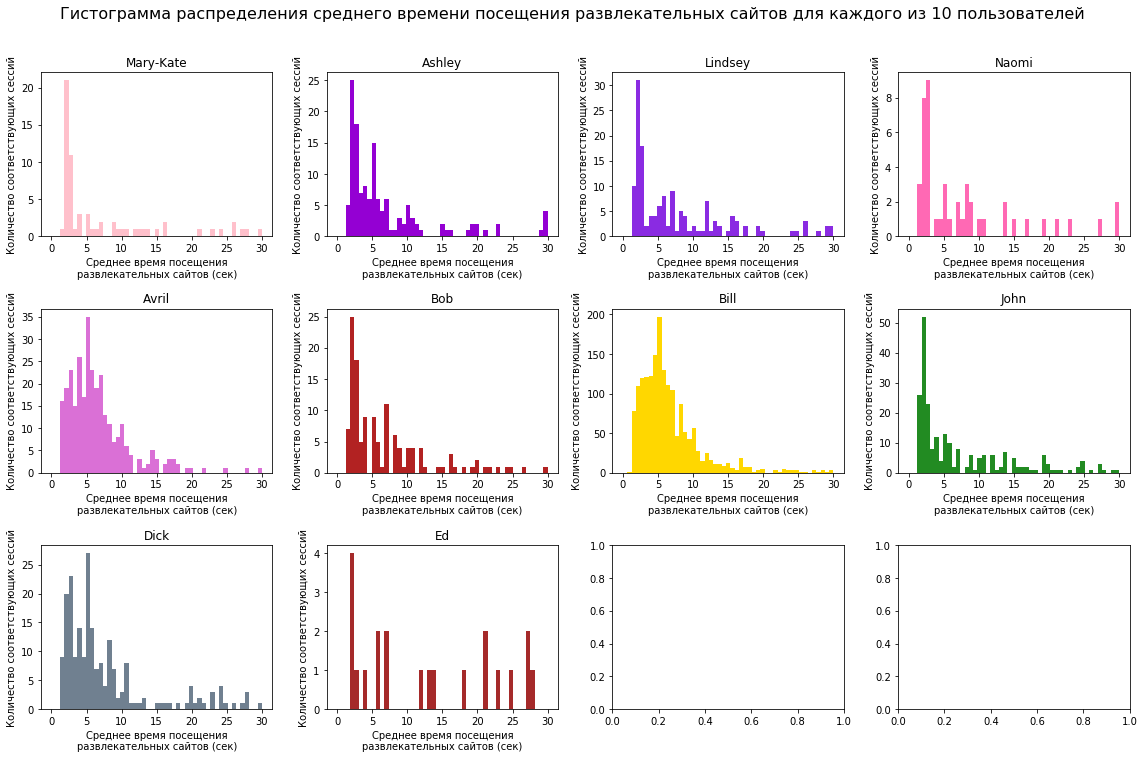

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_10users_te_nz.target.unique())):
    x = new_features_10users_te_nz.loc[new_features_10users_te_nz.target==target, 'time_entertainm']
    ax.hist(x, bins=np.linspace(0, 30), label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    #ax.set_xticks(range(1, 10))
    ax.set_xlabel('Среднее время посещения\nразвлекательных сайтов (сек)')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени посещения развлекательных сайтов для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

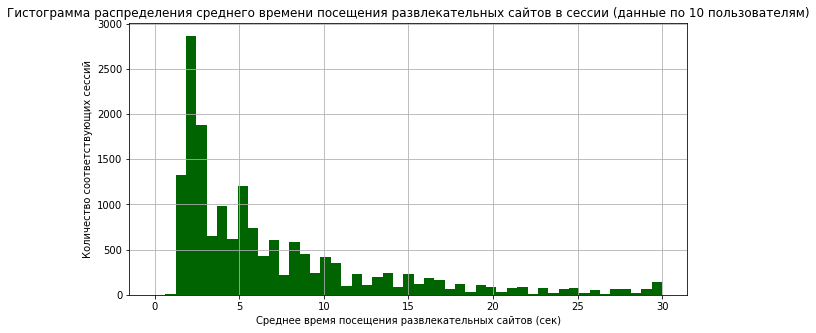

In [89]:
new_features_150users_te_nz['time_entertainm'].hist(bins=np.linspace(0, 30), color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения среднего времени посещения развлекательных сайтов в сессии (данные по 10 пользователям)')
plt.xlabel('Среднее время посещения развлекательных сайтов (сек)')
plt.ylabel('Количество соответствующих сессий')
plt.show()

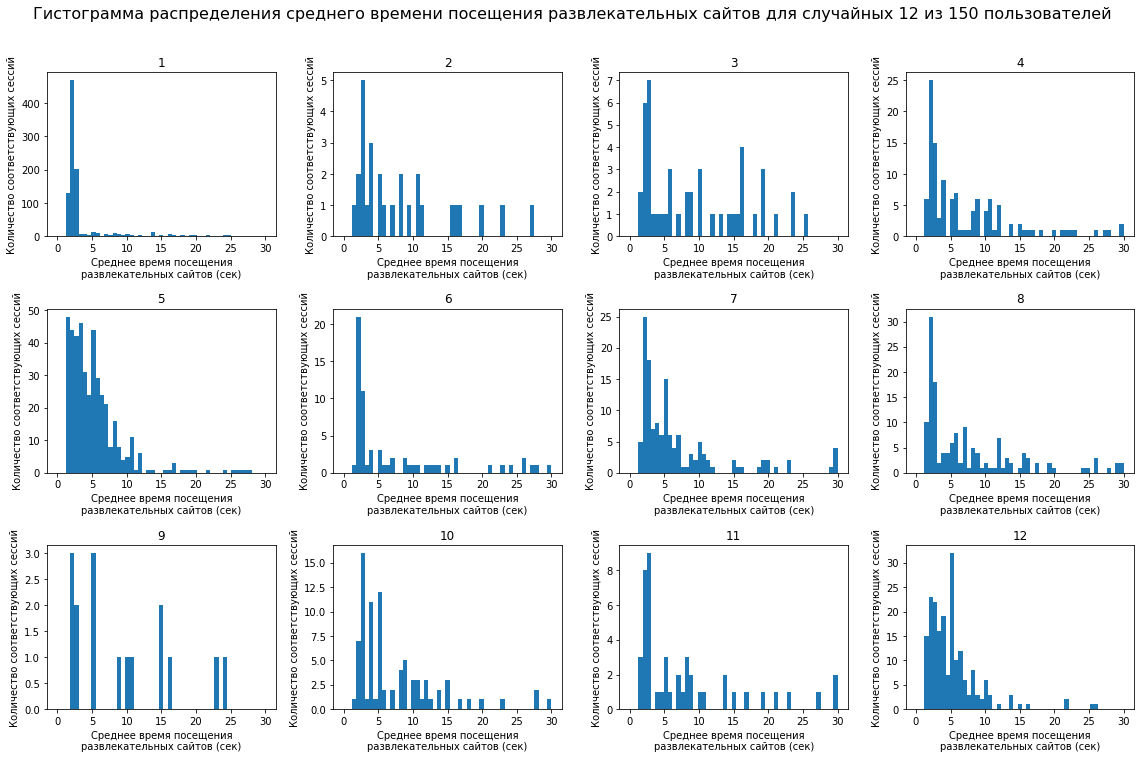

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_150users_te_nz.target.unique())):
    x = new_features_150users_te_nz.loc[new_features_150users_te_nz.target==target, 'time_entertainm']
    ax.hist(x, bins=np.linspace(0, 30), label=str(target)) #, bins=range(24)
    ax.set_title(target)
    #ax.set_xticks(range(1, 10))
    ax.set_xlabel('Среднее время посещения\nразвлекательных сайтов (сек)')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени посещения развлекательных сайтов для случайных 12 из 150 пользователей', y=1.05, size = 16)
plt.tight_layout();

Посмотрим на кол-во сайтов из топ-30 в сессии

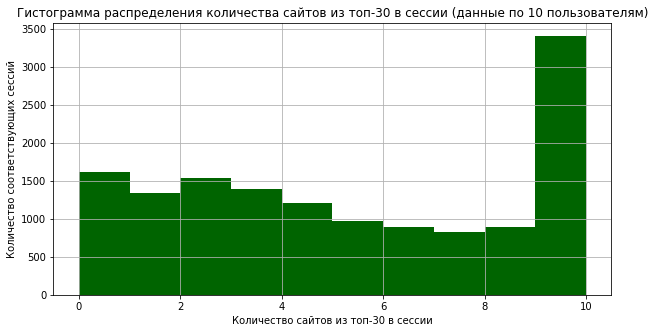

In [91]:
new_features_10users['num_top_30'].hist(color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения количества сайтов из топ-30 в сессии (данные по 10 пользователям)')
plt.xlabel('Количество сайтов из топ-30 в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

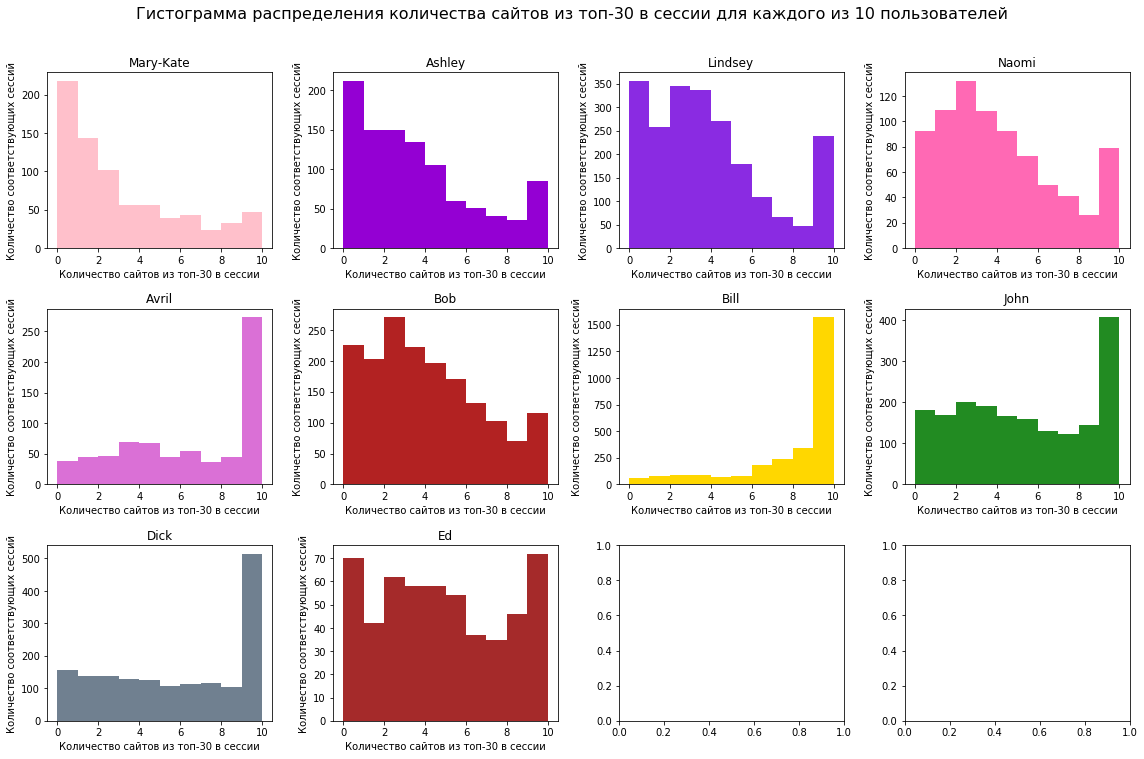

In [92]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_10users.target.unique())):
    x = new_features_10users.loc[new_features_10users.target==target, 'num_top_30']
    ax.hist(x, label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    ax.set_xlabel('Количество сайтов из топ-30 в сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения количества сайтов из топ-30 в сессии для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

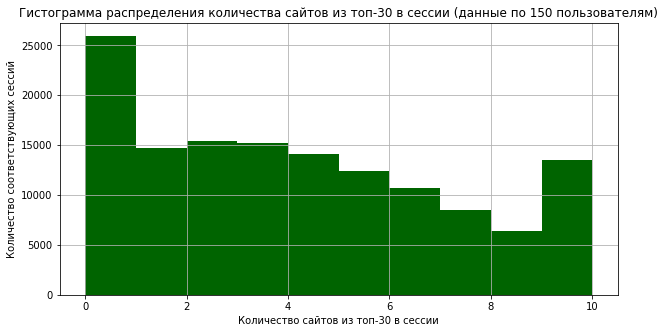

In [93]:
new_features_150users['num_top_30'].hist(color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения количества сайтов из топ-30 в сессии (данные по 150 пользователям)')
plt.xlabel('Количество сайтов из топ-30 в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

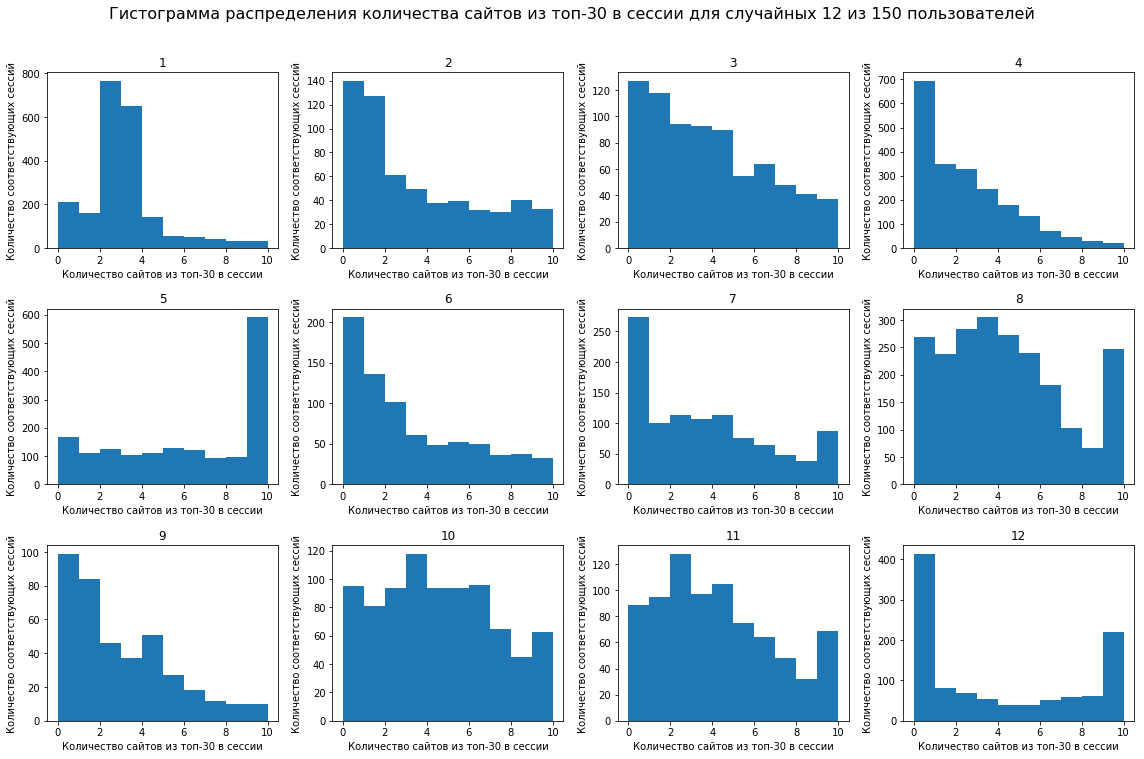

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_150users.target.unique())):
    x = new_features_150users.loc[new_features_150users.target==target, 'num_top_30']
    ax.hist(x, label=str(target)) #, bins=range(24)
    ax.set_title(target)
    ax.set_xlabel('Количество сайтов из топ-30 в сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения количества сайтов из топ-30 в сессии для случайных 12 из 150 пользователей', y=1.05, size = 16)
plt.tight_layout();

Теперь исследуем среднее время посещение сайтов из топ-30

In [95]:
# Здесь также имеет смысл ограничиться посещениямит длиннее 1 секунды и короче 30 секунд
new_features_10users_t30_nz = new_features_10users[new_features_10users['time_top_30'] > 1]
new_features_150users_t30_nz = new_features_150users[new_features_150users['time_top_30'] > 1]
new_features_150users_r12_t30_nz = new_features_150users_r12[new_features_150users_r12['time_top_30'] > 1]

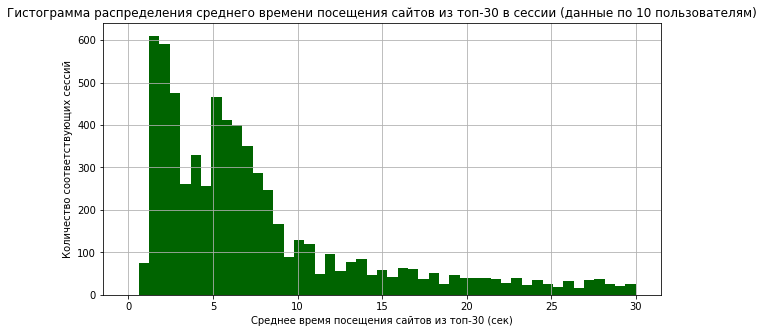

In [96]:
new_features_10users_t30_nz['time_top_30'].hist(bins=np.linspace(0, 30), color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения среднего времени посещения сайтов из топ-30 в сессии (данные по 10 пользователям)')
plt.xlabel('Среднее время посещения сайтов из топ-30 (сек)')
plt.ylabel('Количество соответствующих сессий')
plt.show()

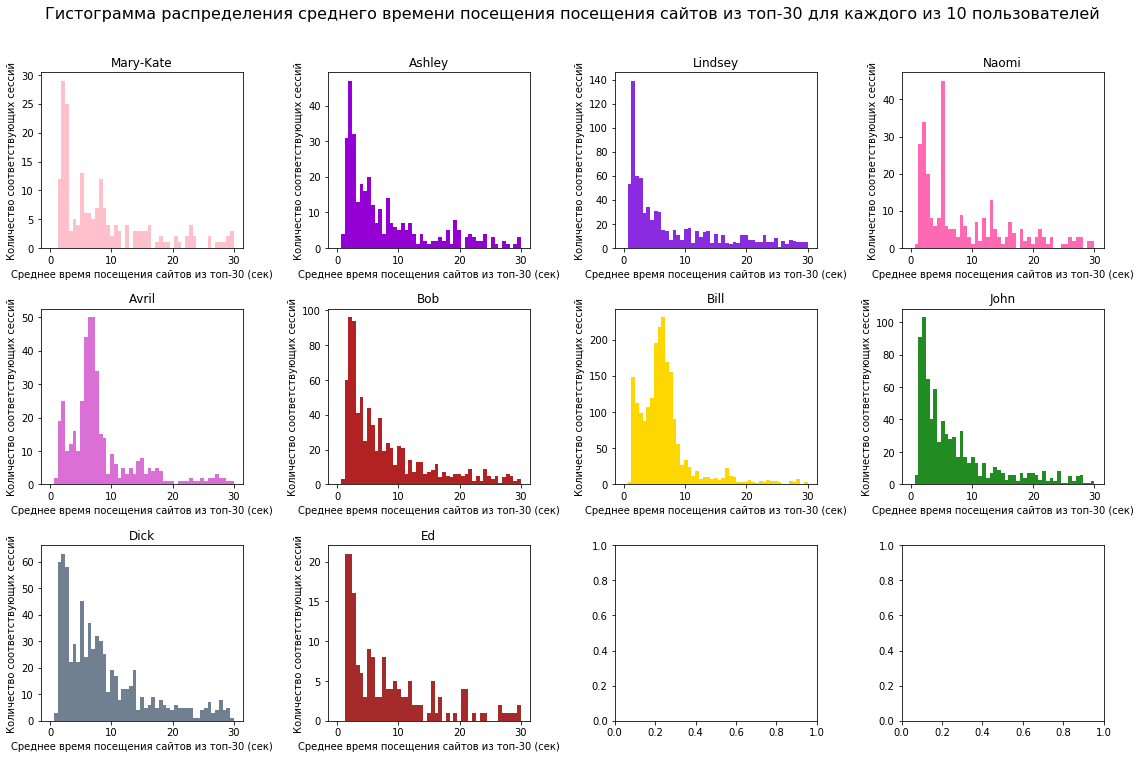

In [97]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_10users_t30_nz.target.unique())):
    x = new_features_10users_t30_nz.loc[new_features_10users_t30_nz.target==target, 'time_top_30']
    ax.hist(x, bins=np.linspace(0, 30), label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    #ax.set_xticks(range(1, 10))
    ax.set_xlabel('Среднее время посещения сайтов из топ-30 (сек)')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени посещения посещения сайтов из топ-30 для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

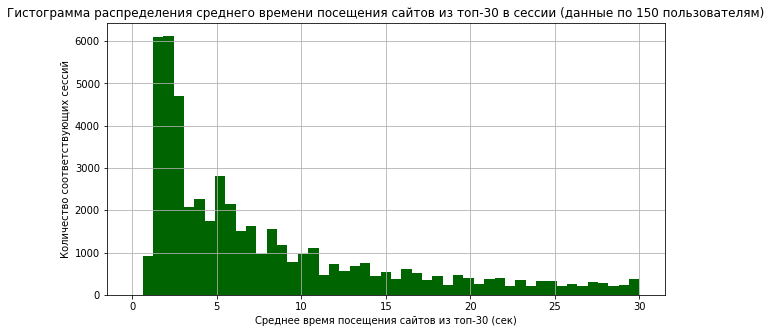

In [98]:
new_features_150users_t30_nz['time_top_30'].hist(bins=np.linspace(0, 30), color='darkgreen', figsize=(10,5))
plt.title('Гистограмма распределения среднего времени посещения сайтов из топ-30 в сессии (данные по 150 пользователям)')
plt.xlabel('Среднее время посещения сайтов из топ-30 (сек)')
plt.ylabel('Количество соответствующих сессий')
plt.show()

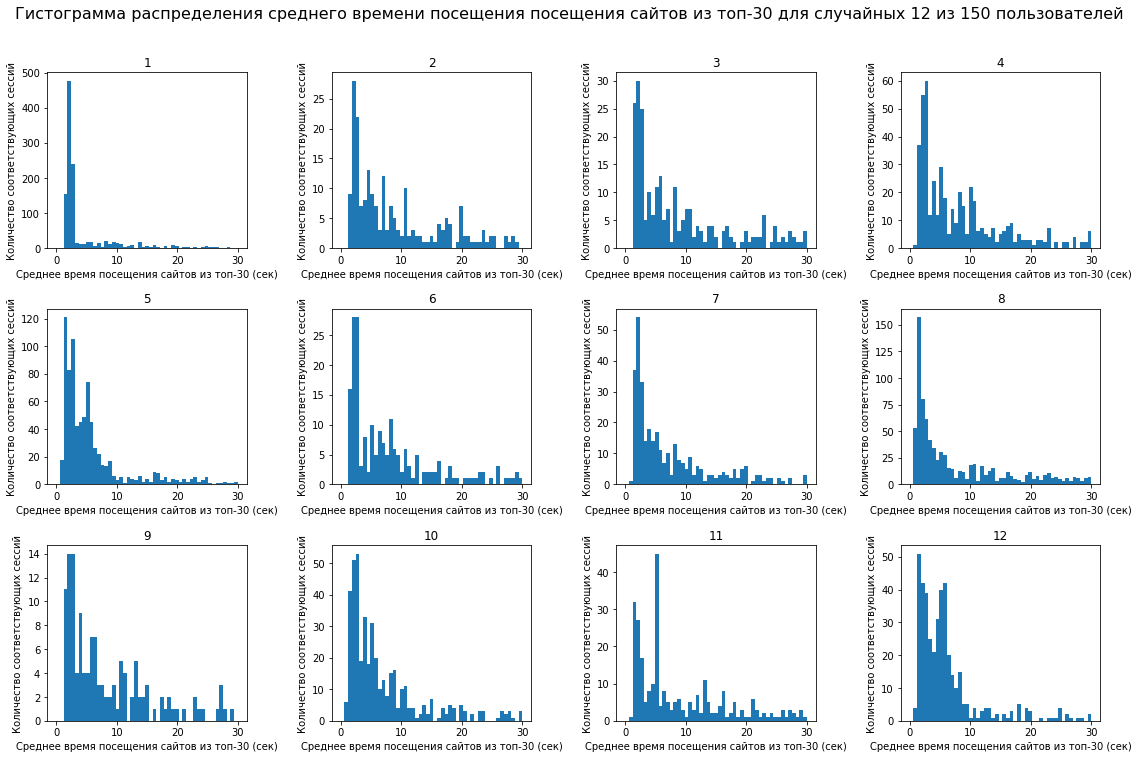

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_150users_t30_nz.target.unique())):
    x = new_features_150users_t30_nz.loc[new_features_150users_t30_nz.target==target, 'time_top_30']
    ax.hist(x, bins=np.linspace(0, 30), label=str(target)) #, bins=range(24)
    ax.set_title(target)
    #ax.set_xticks(range(1, 10))
    ax.set_xlabel('Среднее время посещения сайтов из топ-30 (сек)')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени посещения посещения сайтов из топ-30 для случайных 12 из 150 пользователей', y=1.05, size = 16)
plt.tight_layout();

И, наконец, переходим к времени суток

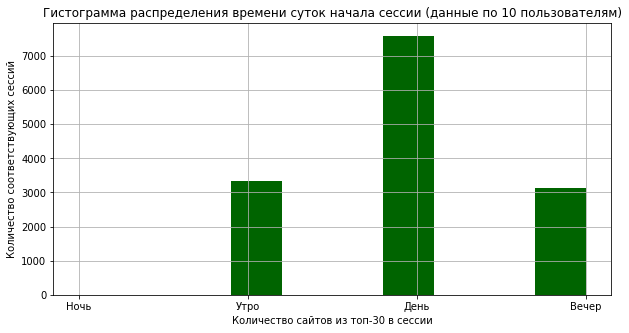

In [100]:
dtimes = ('Ночь', 'Утро', 'День', 'Вечер')
new_features_10users['time_of_day'].hist(color='darkgreen', figsize=(10,5))
plt.xticks(range(4), dtimes)
plt.title('Гистограмма распределения времени суток начала сессии (данные по 10 пользователям)')
plt.xlabel('Количество сайтов из топ-30 в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

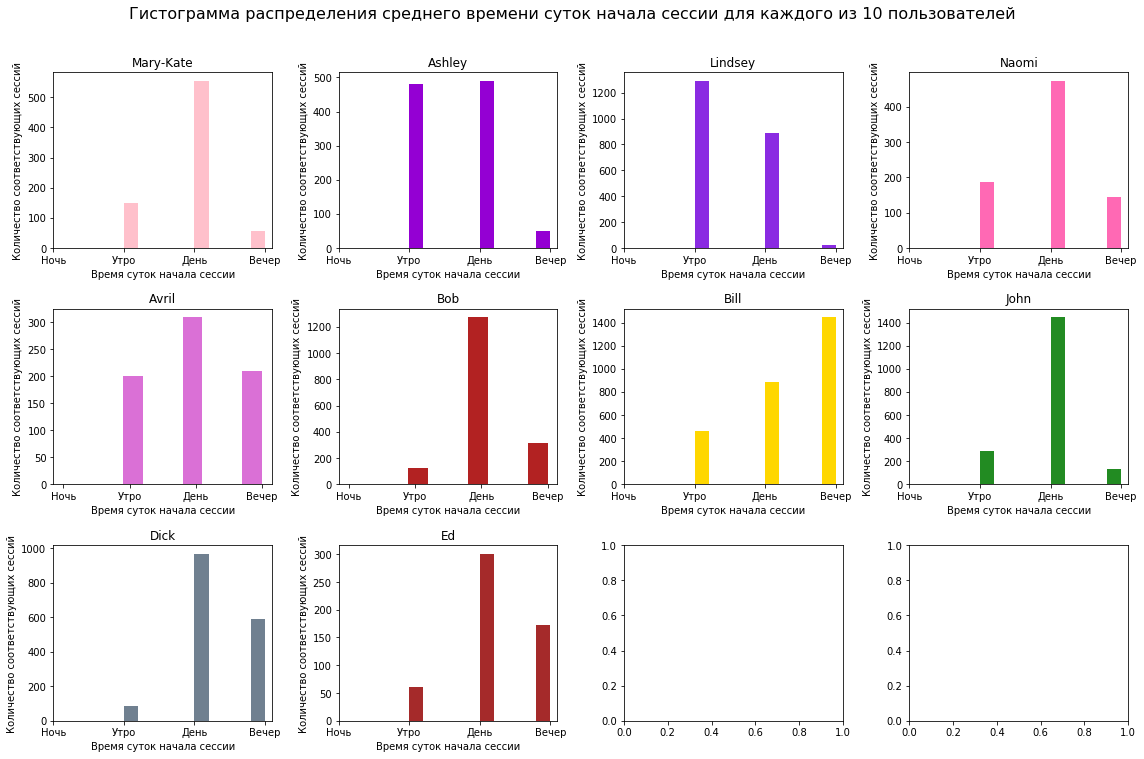

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_10users.target.unique())):
    x = new_features_10users.loc[new_features_10users.target==target, 'time_of_day']
    ax.hist(x, label=str(target), color=color_dic[target]) #, bins=range(24)
    ax.set_title(target)
    ax.set_xticklabels(dtimes)
    ax.set_xticks(range(4))
    ax.set_xlabel('Время суток начала сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени суток начала сессии для каждого из 10 пользователей', y=1.05, size = 16)
plt.tight_layout();

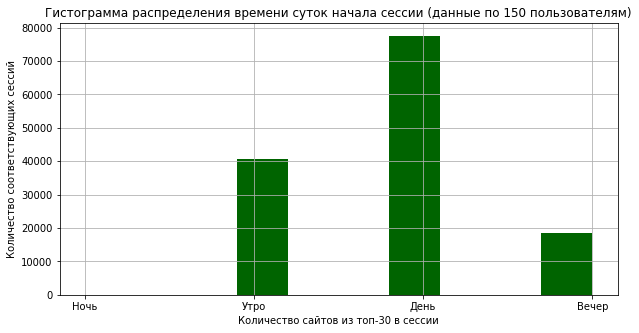

In [102]:
new_features_150users['time_of_day'].hist(color='darkgreen', figsize=(10,5))
plt.xticks(range(4), dtimes)
plt.title('Гистограмма распределения времени суток начала сессии (данные по 150 пользователям)')
plt.xlabel('Количество сайтов из топ-30 в сессии')
plt.ylabel('Количество соответствующих сессий')
plt.show()

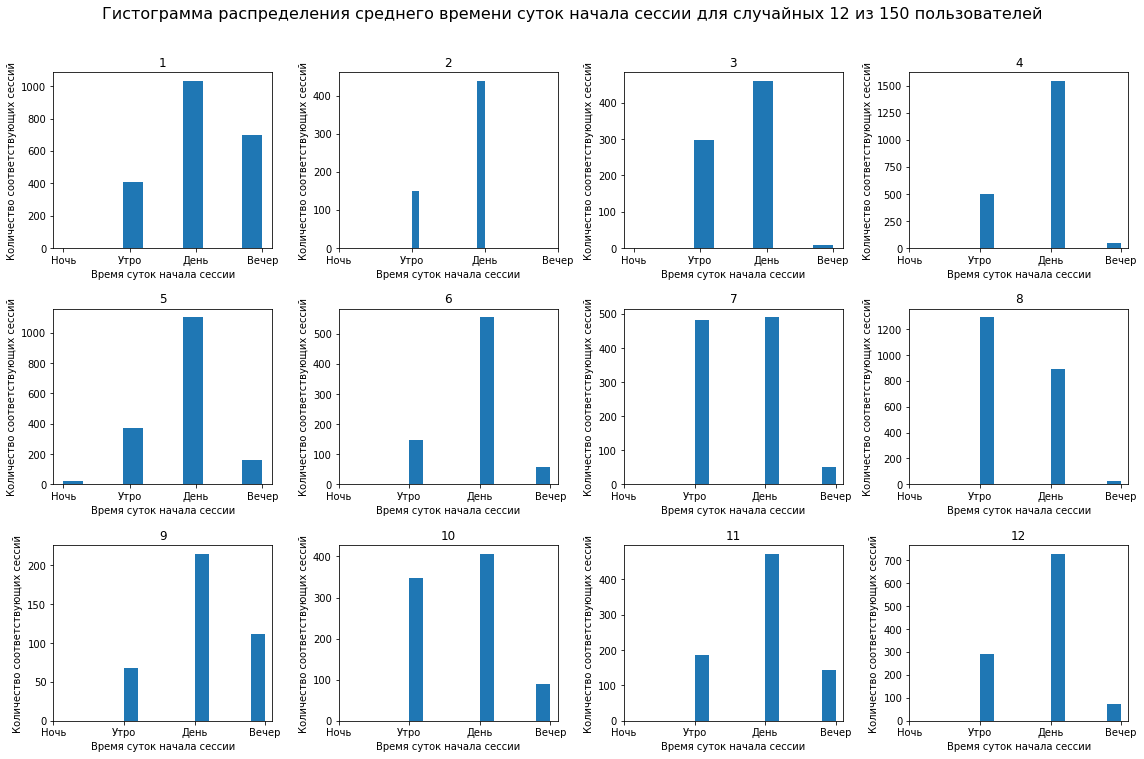

In [103]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (ax, target) in enumerate(zip(axes.flatten(), new_features_150users.target.unique())):
    x = new_features_150users.loc[new_features_150users.target==target, 'time_of_day']
    ax.hist(x, label=str(target)) #, bins=range(24)
    ax.set_title(target)
    ax.set_xticklabels(dtimes)
    ax.set_xticks(range(4))
    ax.set_xlabel('Время суток начала сессии')
    ax.set_ylabel('Количество соответствующих сессий')

plt.suptitle('Гистограмма распределения среднего времени суток начала сессии для случайных 12 из 150 пользователей', y=1.05, size = 16)
plt.tight_layout();

Гистограммы времени, проведенного на развлекательных сайтах или сайтах из топ-30, у большинства пользователей похожи. Более заметные различия дают показатели кол-ва сайтов из топ-30 или развлекательных сайтов. Время суток - дискретный показатель, который может быть полезен для классификации в дальнейшем. При этом у него будет очень высокая корреляция с часом начала сессии, поэтому один из них придется впоследствии убрать. Но пока оставим оба. В итоге из новых показателей оставляем 3: кол-во развлекательных сайтов в сессии, кол-во сайтов из топ-30 в сессии, время суток начала сессии. Из ранее рассмотренных показателей не очень информативным выглядит кол-во уникальных сайтов в сессии, но пока оставляем все.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [104]:
selected_features_10users = new_features_10users.drop(columns=['time_entertainm', 'time_top_30'])
selected_features_150users = new_features_150users.drop(columns=['time_entertainm', 'time_top_30'])

In [105]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 